# 2차 EDA

In [51]:
import os
import cv2
import math
import json
import random
import platform
import matplotlib
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patches as patches

from tqdm import tqdm

from PIL import Image
from collections import Counter, defaultdict
from pycocotools.coco import COCO


os_name = platform.system()

if os_name == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
    root = 'C:/Users/yeyec/workspace/server2'
else:
    root = '/data/ephemeral/home'


source = root + '/dataset/train.json'
image_dir  = root + '/dataset/train'


with open(source, 'r') as file:
    data = json.load(file)

# 클래스 컬러 설정
class_colors = { 
    0: (1, 101, 132),    # General trash
    1: (244, 165, 127),  # Paper
    2: (247, 225, 168),  # Paper pack
    3: (3, 137, 153),    # Metal
    4: (138, 204, 165),  # Glass
    5: (210, 231, 174),  # Plastic
    6: (245, 195, 141),  # Styrofoam
    7: (66, 173, 162),   # Plastic bag
    8: (226, 100, 133),  # Battery
    9: (239, 132, 126)   # Clothing
}

color3 = [(251, 218, 171), (255, 167, 71), (0, 166, 255)]

normalized_class_colors = {class_id: (r/255, g/255, b/255) for class_id, (r, g, b) in class_colors.items()}

In [52]:
if 'categories' in data:
    categories = data['categories']
    id_to_name = {category['id']: category['name'] for category in categories}

    categories_id_name = {cat['id']: cat['name'] for cat in categories}
    

if 'annotations' in data:
    annotations = data['annotations']


if 'images' in data:
    images = data['images']
    images_id_img = {img['id']: img for img in data['images']}


num_images = len(images)
num_annotations = len(annotations)
num_categories = len(categories)

print(f"Num of Images: {num_images}")
print(f"Num of Annotations: {num_annotations}")
print(f"Num of Categories: {num_categories}")

Num of Images: 4883
Num of Annotations: 23144
Num of Categories: 10


In [53]:
# 'categories' 배열에서 class_id와 class_name을 추출합니다.
#print("Class ID, Name")

for id, name in categories_id_name.items():
    pass
    # print(f"{id} {name}")

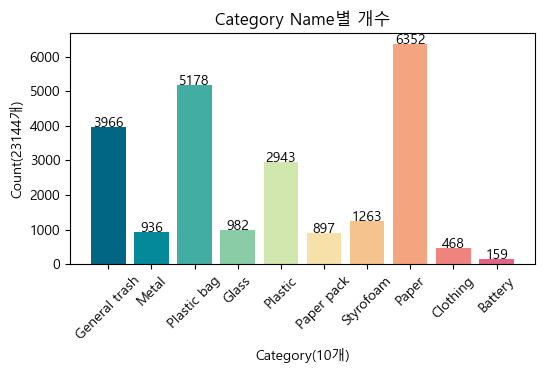

In [54]:
if 'annotations' in data:
    category_ids = [item['category_id'] for item in annotations]
    category_id_count = Counter(category_ids)
    
    category_count = list(category_id_count.keys())
    counts = list(category_id_count.values())

    colors = [normalized_class_colors[cat_id] for cat_id in category_count]
    category_names = [id_to_name[cat_id] for cat_id in category_count]

    plt.figure(figsize=(6, 3))
    bars = plt.bar(category_names, counts, color=colors)
    plt.xlabel(f'Category({num_categories}개)')
    plt.ylabel(f'Count({num_annotations}개)')
    plt.title('Category Name별 개수')
    plt.xticks(rotation=45)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center')

    
    plt.show()

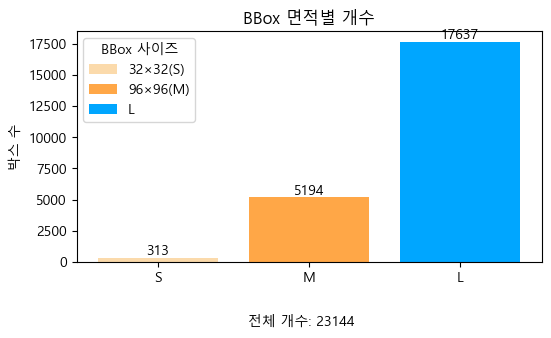

Size L: 17637개(76.0%)
Size M: 5194개(22.0%)
Size S: 313개(1.0%)
총 bbox 개수: 23144개


In [55]:
import json
import matplotlib.pyplot as plt
from collections import Counter

# 임계값 정의 (S: 32^2 이하, M: 32^2 ~ 96^2, L: 96^2 이상)
small_threshold = 32 ** 2
medium_threshold = 96 ** 2

size_categories = []

for annotation in annotations:
    bbox = annotation['bbox']
    width, height = bbox[2], bbox[3]
    area = width * height
    
    if area <= small_threshold:
        size_categories.append('S')
    elif small_threshold < area <= medium_threshold:
        size_categories.append('M')
    else:
        size_categories.append('L')


size_count = Counter(size_categories)

plt.figure(figsize=(6, 3))
size_keys_reversed = list(size_count.keys())[::-1]
size_values_reversed = list(size_count.values())[::-1]

bars = plt.bar(size_keys_reversed, size_values_reversed, color=[(r/255, g/255, b/255) for r, g, b in color3], label=['32×32(S)', '96×96(M)', 'L'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.figtext(0.5, -0.1, f'전체 개수: {num_annotations}', ha='center', fontsize=10)

plt.legend(title="BBox 사이즈")

plt.ylabel('박스 수')
plt.title('BBox 면적별 개수')
plt.show()

for size, count in size_count.items():
    print(f"Size {size}: {count}개({count/num_annotations *10000 // 100}%)")
print(f"총 bbox 개수: {num_annotations}개")

### 클래스별 bbox 개수

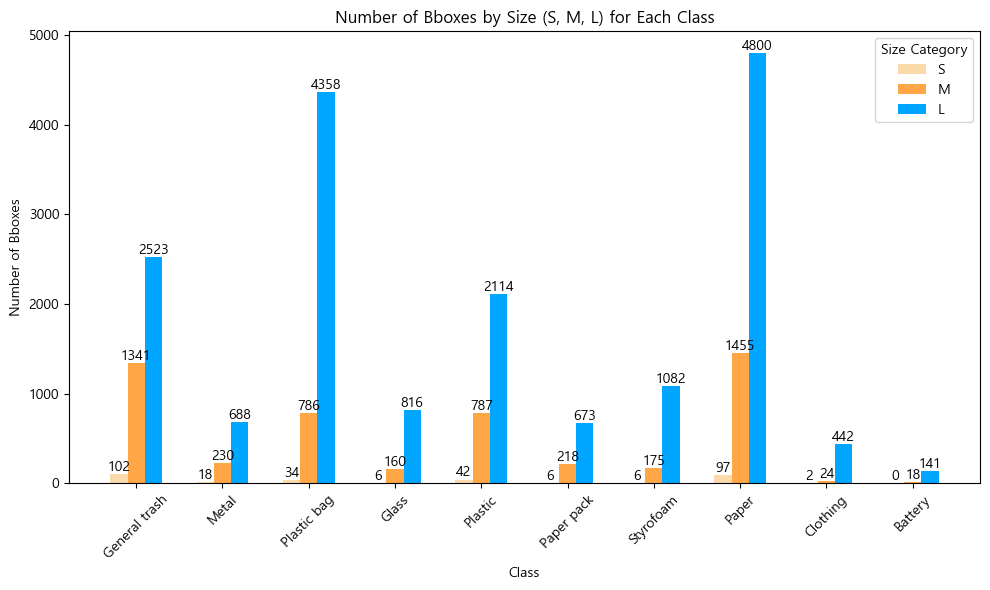

      Class Name  S (%)  M (%)  L (%)
0  General trash    2.6   33.8   63.6
1          Metal    1.9   24.6   73.5
2    Plastic bag    0.7   15.2   84.2
3          Glass    0.6   16.3   83.1
4        Plastic    1.4   26.7   71.8
5     Paper pack    0.7   24.3   75.0
6      Styrofoam    0.5   13.9   85.7
7          Paper    1.5   22.9   75.6
8       Clothing    0.4    5.1   94.4
9        Battery    0.0   11.3   88.7

      Class Name  S Count  M Count  L Count
0  General trash      102     1341     2523
1          Metal       18      230      688
2    Plastic bag       34      786     4358
3          Glass        6      160      816
4        Plastic       42      787     2114
5     Paper pack        6      218      673
6      Styrofoam        6      175     1082
7          Paper       97     1455     4800
8       Clothing        2       24      442
9        Battery        0       18      141


In [56]:
class_size_count = defaultdict(lambda: {'S': 0, 'M': 0, 'L': 0})

for annotation in annotations:
    bbox = annotation['bbox']
    class_id = annotation['category_id']
    width, height = bbox[2], bbox[3]
    area = width * height
    
    # 크기 카테고리에 따라 S, M, L 분류
    if area <= small_threshold:
        class_size_count[class_id]['S'] += 1
    elif small_threshold < area <= medium_threshold:
        class_size_count[class_id]['M'] += 1
    else:
        class_size_count[class_id]['L'] += 1

# 클래스별로 S, M, L 개수 데이터를 준비
classes = list(class_size_count.keys())
S_count = [class_size_count[cls]['S'] for cls in classes]
M_count = [class_size_count[cls]['M'] for cls in classes]
L_count = [class_size_count[cls]['L'] for cls in classes]

class_names = [categories_id_name.get(cls, f'Class {cls}') for cls in classes]


fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = range(len(classes))

bars1 = ax.bar(index, S_count, bar_width, label='S', color=(color3[0][0]/255, color3[0][1]/255, color3[0][2]/255))
bars2 = ax.bar([i + bar_width for i in index], M_count, bar_width, label='M', color=(color3[1][0]/255, color3[1][1]/255, color3[1][2]/255))
bars3 = ax.bar([i + 2 * bar_width for i in index], L_count, bar_width, label='L', color=(color3[2][0]/255, color3[2][1]/255, color3[2][2]/255))

ax.set_xlabel('Class')
ax.set_ylabel('Number of Bboxes')
ax.set_title('Number of Bboxes by Size (S, M, L) for Each Class')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(class_names, rotation=45)

ax.legend(title="Size Category")

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

class_names = [categories_id_name.get(cls, f'Class {cls}') for cls in classes]
s_counts = [class_size_count[cls]['S'] for cls in classes]
m_counts = [class_size_count[cls]['M'] for cls in classes]
l_counts = [class_size_count[cls]['L'] for cls in classes]

df = pd.DataFrame({
    'Class Name': class_names,
    'S Count': s_counts,
    'M Count': m_counts,
    'L Count': l_counts
})


class_names = [categories_id_name.get(cls, f'Class {cls}') for cls in classes]
s_counts = [class_size_count[cls]['S'] for cls in classes]
m_counts = [class_size_count[cls]['M'] for cls in classes]
l_counts = [class_size_count[cls]['L'] for cls in classes]

total_counts = [s + m + l for s, m, l in zip(s_counts, m_counts, l_counts)]


s_ratios = [s / total if total > 0 else 0 for s, total in zip(s_counts, total_counts)]
m_ratios = [m / total if total > 0 else 0 for m, total in zip(m_counts, total_counts)]
l_ratios = [l / total if total > 0 else 0 for l, total in zip(l_counts, total_counts)]


df_ratios = pd.DataFrame({
    'Class Name': class_names,
    'S (%)': [ratio * 100 for ratio in s_ratios],
    'M (%)': [ratio * 100 for ratio in m_ratios],
    'L (%)': [ratio * 100 for ratio in l_ratios]
})

df_ratios = df_ratios.round(1)

print(df_ratios)
print()
print(df)

### 각 fold에서 class별 bbox 사이즈 S/M/L 개수 비교

In [57]:
# Faster R-CNN에서 mapper없이 iter:8000 batch_size:4로 학습하였을 때 ap값
ap_data = {
    "General trash": [20.533, 18.404, 17.162, 17.191, 17.330],
    "Metal": [40.291, 35.142, 27.038, 38.836, 30.623],
    "Styrofoam": [35.501, 34.128, 31.924, 31.715, 29.341],
    "Clothing": [39.228, 28.945, 29.380, 28.945, 40.877],
    "Paper": [29.679, 29.242, 29.805, 28.404, 27.275],
    "Glass": [42.508, 34.319, 32.490, 41.668, 42.571],
    "Plastic bag": [52.525, 52.543, 53.290, 50.556, 54.407],
    "Paper pack": [38.887, 39.318, 34.027, 30.975, 38.657],
    "Plastic": [26.144, 26.541, 25.756, 26.789, 23.954],
    "Battery": [71.470, 36.025, 55.581, 52.738, 39.301]
}

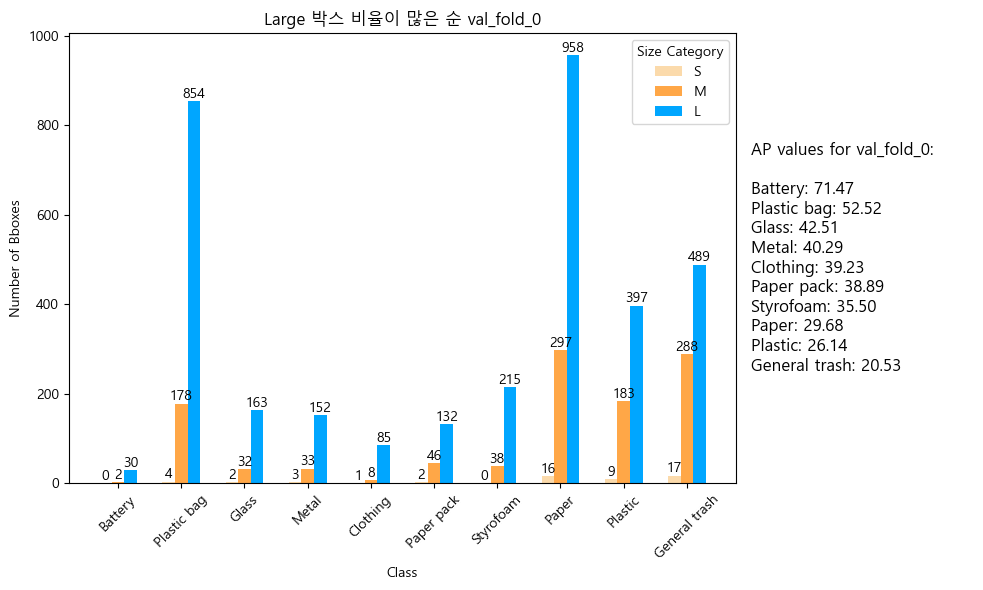

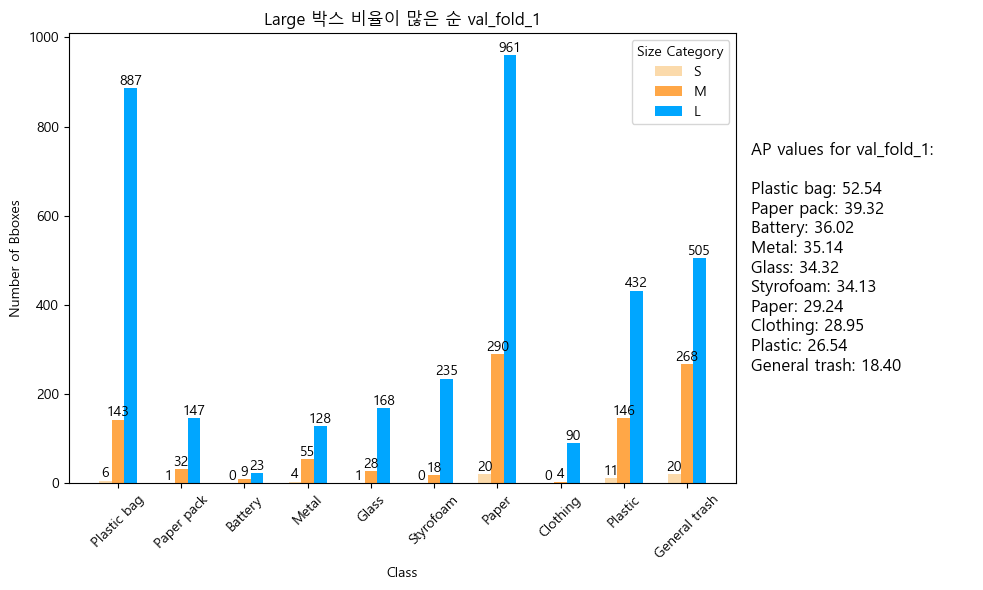

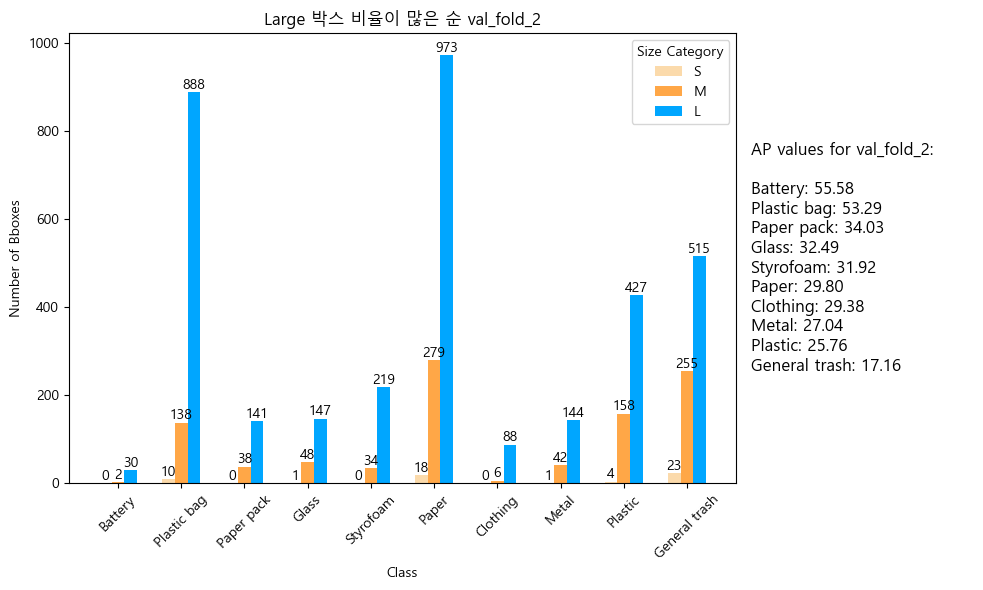

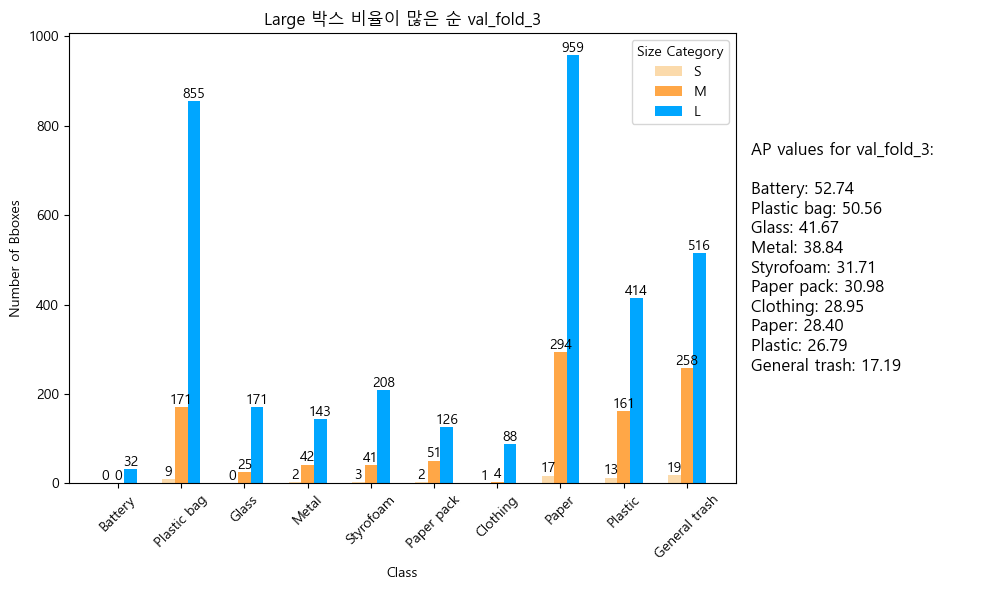

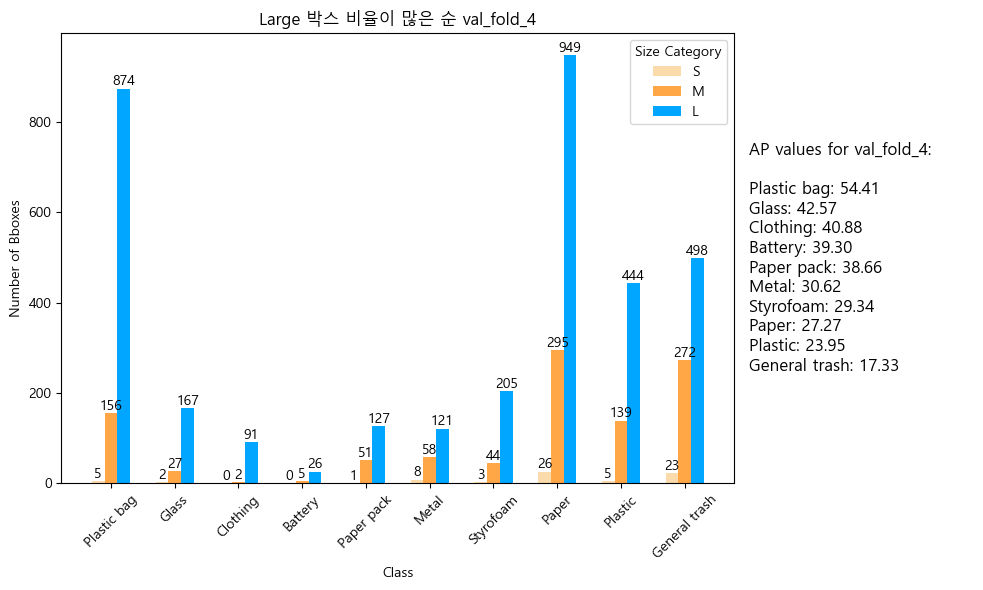

In [60]:
file_paths = [f'{root}/dataset/val_fold_{i}.json' for i in range(5)]

for i, file_path in enumerate(file_paths):
    if not os.path.exists(file_path):
        print(f"File {file_path} not found.")
        continue

    with open(file_path, 'r') as f:
        data = json.load(f)
    
    categories = data['categories']
    annotations = data['annotations']

    id_to_name = {category['id']: category['name'] for category in categories}
    name_to_id = {name: id_ for id_, name in id_to_name.items()}

    class_size_count = defaultdict(lambda: {'S': 0, 'M': 0, 'L': 0})

    for annotation in annotations:
        bbox = annotation['bbox']
        class_id = annotation['category_id']
        width, height = bbox[2], bbox[3]
        area = width * height

        if area <= small_threshold:
            class_size_count[class_id]['S'] += 1
        elif small_threshold < area <= medium_threshold:
            class_size_count[class_id]['M'] += 1
        else:
            class_size_count[class_id]['L'] += 1

    ap_classes = list(ap_data.keys())

    
    sorted_ap_classes = sorted(ap_classes, key=lambda cls: ap_data[cls][i], reverse=True)

    
    S_count = [class_size_count[name_to_id.get(cls, 0)]['S'] for cls in sorted_ap_classes]
    M_count = [class_size_count[name_to_id.get(cls, 0)]['M'] for cls in sorted_ap_classes]
    L_count = [class_size_count[name_to_id.get(cls, 0)]['L'] for cls in sorted_ap_classes]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [3, 1]})  # 2개의 subplot, 2:1 비율

    bar_width = 0.2
    index = range(len(sorted_ap_classes))

    
    bars1 = ax1.bar(index, S_count, bar_width, label='S', color=(color3[0][0]/255, color3[0][1]/255, color3[0][2]/255))
    bars2 = ax1.bar([i + bar_width for i in index], M_count, bar_width, label='M', color=(color3[1][0]/255, color3[1][1]/255, color3[1][2]/255))
    bars3 = ax1.bar([i + 2 * bar_width for i in index], L_count, bar_width, label='L', color=(color3[2][0]/255, color3[2][1]/255, color3[2][2]/255))

    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Bboxes')
    ax1.set_title(f'Large 박스 비율이 많은 순 val_fold_{i}')
    ax1.set_xticks([i + bar_width for i in index])
    ax1.set_xticklabels(sorted_ap_classes, rotation=45)

    ax1.legend(title="Size Category")

    
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            yval = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

    
    ap_values = {cls: ap_data[cls][i] for cls in sorted_ap_classes}
    ap_text = "\n".join([f"{cls}: {ap_values[cls]:.2f}" for cls in sorted_ap_classes])

    ax2.axis('off')
    ax2.text(0, 0.5, f"AP values for val_fold_{i}:\n\n{ap_text}", fontsize=12, va='center')

    plt.tight_layout()
    plt.show()



- Large 박스가 많을수록 ap가 높고, small & medium 박스가 많을수록 ap가 낮았다
- small과 medium 박스가 많은 General trash, Plastic, Paper의 ap가 가장 낮았으며, 이에 대한 탐지 성능 개선이 필요해보인다
- 가장 높은 Large 박스 비율을 보이는 Clothing의 AP가 좋지 않은 것은 오분류 문제인지 정확한 확인이 필요하다
- 모든 fold에서 높은 점수를 보이는 Battery의 경우 작은 박스 비율이 가장 낮았다